In [1]:
#Importa as bibliotecas

import init


from analisys.bkt_analisys import *
from analisys.data_analisys import *
from analisys.graph_analisys import *
from analisys.optmizer_analisys import *

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

from scipy.interpolate import interp1d

import seaborn as sns
sns.set_theme()

import random
import os
import plotly.express as px
from backend import *
from backend.resampler import *
from backend.mt5_tools import *

from statsmodels.tsa.stattools import adfuller
from analisys.graph_analisys import moving_avg

from scipy.optimize import rosen, differential_evolution

def sigmoid(x):
    z = 1/(1 + np.exp(-2*x))
    return z

In [2]:
start_date = '2022.02.20'
end_date = '2022.02.26'

name_x = 'BPAC11'
name_y = 'MULT3'

timeframe = 5


s_spread = 0
l_spread = -2
tp_short = 0
tp_long = 1
tp_return = 2694
stop_return = -36
stop_number = 47
period = 178     #afeta
min_count = 176
p_size = 10000


hist_x = mt5_singlehistoricaldata(name_x,timeframe, start_date, end_date)
hist_y = mt5_singlehistoricaldata(name_y,timeframe, start_date, end_date)

hist_x.replace(0, np.NaN, inplace=True)
hist_x = hist_x.interpolate(method='linear', limit_direction='forward', axis=0)

hist_y.replace(0, np.NaN, inplace=True)
hist_y = hist_y.interpolate(method='linear', limit_direction='forward', axis=0)



In [3]:
result = runbkt(hist_x, hist_y, name_x, name_y, period, s_spread, l_spread, tp_short, tp_long, stop_number, min_count ,p_size)


In [4]:
for i in result['positions_list']:
    print(i['profit'])


37.999999999999545


In [5]:
def pos_info(result_list):
    for i in range(len(result_list)):
        print('######')
        _a = result_list[0]['type']
        _b = result_list[0]['profit']
        _c = result_list[0]['df_yprice'], result['positions_list'][0]['df_xprice']
        _d = result_list[0]['df_date']

        print('type : {} | profit : {} | price : {} | date : {} \n'.format(_a, _b, _c, str(_d)))

pos_info(result['positions_list'])


######
type : short_spread | profit : 37.999999999999545 | price : ([22.12, 21.76], [25.82, 25.47]) | date : [Timestamp('2022-02-23 12:25:00'), Timestamp('2022-02-25 16:25:00')] 



In [6]:
l = []

for i in result['positions_list']:
    print(i['type'], i['df_xprice'], i['df_yprice'], i['profit'])
    l.append(i['profit'])

print(sum(l))


short_spread [25.82, 25.47] [22.12, 21.76] 37.999999999999545
37.999999999999545


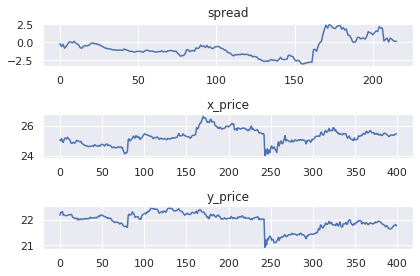

In [7]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(result['spread'])
axs[0].set_title('spread')
axs[1].plot(result['price']['x_price'])
axs[1].set_title('x_price')
axs[2].plot(result['price']['y_price'])
axs[2].set_title('y_price')
fig.tight_layout()





In [8]:

positions_markers_buy = []
positions_markers_sell = []

for mark in result['positions_list']:

    if(mark['type'] == 'long_spread'):
        positions_markers_buy.append(mark['df_iteration'][1])
        positions_markers_sell.append(mark['df_iteration'][0])

    if(mark['type'] == 'short_spread'):
        positions_markers_buy.append(mark['df_iteration'][0])
        positions_markers_sell.append(mark['df_iteration'][1])

        
        
positions_markers_sell, positions_markers_buy



([398], [189])

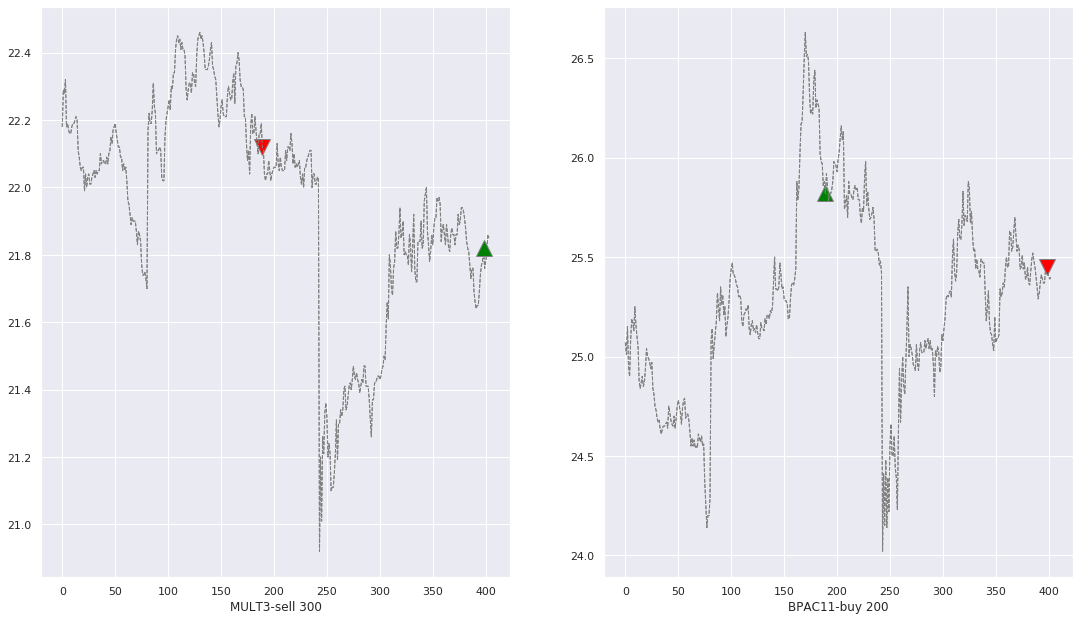

In [9]:


hist_x_open = np.array(hist_x['open'])
hist_x_close = np.array(hist_x['close'])
hist_y_open = np.array(hist_y['open'])
hist_y_close = np.array(hist_y['close'])

#print(hist_y_close)

for idx in np.where(hist_x_close == 0):
    try:
        hist_x_close[idx] = (hist_x_close[idx-1] + hist_x_close[idx+1])/2
    except:
        print('fail')

xs_axis = range(len(hist_x_open))

#short_spread => X_BUY, Y_SELL
#long_spread  => X_SELL, Y_BUY

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

result['positions_list']

#grarficos

for mark in result['positions_list']:
    
    if(mark['type'] == 'long_spread'):
        
        axs[0].plot(hist_x_close,color = 'gray', linestyle='--',  linewidth=1 ,marker='^', markersize=16, markerfacecolor='green', markevery=positions_markers_buy)
        axs[0].plot(hist_x_close, color = 'gray', linestyle='--',linewidth=1 , marker='v', markersize=16, markerfacecolor='red', markevery=positions_markers_sell)
        axs[0].set_xlabel('{}-{} {}'.format(result['info']['x_symbol'],result['positions_list'][result['positions_list'].index(mark)]['x_type'], result['positions_list'][result['positions_list'].index(mark)]['x_volume']))


        axs[1].plot(hist_y_close, color = 'gray', linestyle='--', linewidth=1 ,marker='v', markersize=16, markerfacecolor='red', markevery=positions_markers_buy)
        axs[1].plot(hist_y_close, color = 'gray', linestyle='--', linewidth=1 ,marker='^', markersize=16, markerfacecolor='green', markevery=positions_markers_sell)
        axs[1].set_xlabel('{}-{} {}'.format(result['info']['y_symbol'],result['positions_list'][result['positions_list'].index(mark)]['y_type'], result['positions_list'][result['positions_list'].index(mark)]['y_volume']))
        

    if(mark['type'] == 'short_spread'):

        axs[0].plot(hist_y_close, color = 'gray',linestyle='--',linewidth=1 , marker='v', markersize=16, markerfacecolor='red', markevery=positions_markers_buy)
        axs[0].plot(hist_y_close, color = 'gray', marker='^',linestyle='--',linewidth=1 , markersize=16, markerfacecolor='green', markevery=positions_markers_sell)
        axs[0].set_xlabel('{}-{} {}'.format(result['info']['y_symbol'],result['positions_list'][result['positions_list'].index(mark)]['y_type'], result['positions_list'][result['positions_list'].index(mark)]['y_volume']))
        
        axs[1].plot(hist_x_close, color = 'gray', marker='^',linestyle='--',linewidth=1 , markersize=16, markerfacecolor='green', markevery=positions_markers_buy)
        axs[1].plot(hist_x_close, color = 'gray', marker='v',linestyle='--',linewidth=1 , markersize=16, markerfacecolor='red', markevery=positions_markers_sell)
        axs[1].set_xlabel('{}-{} {}'.format(result['info']['x_symbol'],result['positions_list'][result['positions_list'].index(mark)]['x_type'], result['positions_list'][result['positions_list'].index(mark)]['x_volume']))









95
212.0


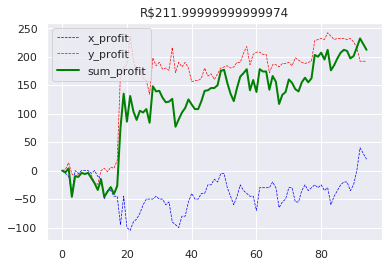

In [10]:
#auxilia a tratar alguns dados

df_iteration = result['positions_list'][0]['df_iteration']

x_lprofit = []
y_lprofit = []
np_hist_x = np.array(hist_x_close)[df_iteration[0]:df_iteration[1]+1]
np_hist_y = np.array(hist_y_close)[df_iteration[0]:df_iteration[1]+1]

x_volume = result['positions_list'][0]['x_volume']
y_volume = result['positions_list'][0]['y_volume']


for i in range(len(np_hist_x)):
    x_lprofit.append(x_volume*np_hist_x[i])
    y_lprofit.append(y_volume*np_hist_y[i])

x_profit = 0
y_profit = 0

for r in range(len(result['positions_list'])):
    if(result['positions_list'][r]['type'] == 'short_spread'):
        x_profit += np.array(x_lprofit) - x_lprofit[0]
        y_profit += -np.array(y_lprofit) + y_lprofit[0]


    if(result['positions_list'][r]['type'] == 'long_spread'):
        x_profit += -np.array(x_lprofit) + x_lprofit[0]
        y_profit += np.array(y_lprofit) - y_lprofit[0]


s_profit = x_profit + y_profit

print(len(x_profit))

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5)



axs.plot(x_profit, label='x_profit', linestyle='--', linewidth=0.7, color='blue')
axs.plot(y_profit, label='y_profit', linestyle='--', linewidth=0.7, color='red')
axs.plot(s_profit,label='sum_profit', linewidth=2, color = 'green')
axs.legend(loc='upper left')
axs.set_title('R${}'.format(result['profit']))

print(s_profit[-1])


In [11]:
num = 0
param_list = []
param_list.append(name_x)
param_list.append(name_y)
param_list.append(p_size)


for i in b[num]:
    param_list.append(i)

print('fourteenbis_live',tuple(param_list))

NameError: name 'b' is not defined